# Softmax Regression Implementation from Scratch
:label:`sec_softmax_scratch`

Because softmax regression is so fundamental,
we believe that you ought to know
how to implement it yourself.
Here, we limit ourselves to defining the
softmax-specific aspects of the model
and reuse the other components
from our linear regression section,
including the training loop.


In [39]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import jax
import jax.numpy as jnp
import optax
from flax import nnx

In [40]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [41]:
x_train = x_train / 255.
y_train = y_train.astype(np.int32)

In [42]:
x_train.shape

(60000, 28, 28)

In [43]:
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data

<_TensorSliceDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [44]:
# when validation step needed
# train_data, val_data = tf.keras.utils.split_dataset(train_data_all, left_size=0.8, shuffle=True)

In [45]:
train_data.cardinality().numpy()

60000

In [46]:
n_epoch = 10
batch_size = 64
train_data = train_data.repeat(n_epoch).shuffle(buffer_size=500)
train_data = train_data.batch(batch_size, drop_remainder=True).prefetch(1)

In [47]:
train_data.cardinality().numpy() # (60000 * n_epoch) / batch_size

9375

In [48]:
test_data = tf.data.Dataset.from_tensor_slices((x_test, y_test))

In [49]:
def normalize_img(X, y):
  X = tf.cast(X, tf.float32) / 255.
  y = tf.cast(y, tf.int32)
  return X, y

test_data = test_data.map(normalize_img)
test_data

<_MapDataset element_spec=(TensorSpec(shape=(28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int32, name=None))>

In [50]:
test_data = test_data.shuffle(500) 
test_data = test_data.batch(batch_size, drop_remainder=True).prefetch(1)
test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(64, 28, 28), dtype=tf.float32, name=None), TensorSpec(shape=(64,), dtype=tf.int32, name=None))>

In [51]:
class SoftReg(nnx.Module):
	def __init__(self, din: int, dout: int, *, rngs: nnx.Rngs):
		key = rngs.params()
		self.w = nnx.Param(jax.random.normal(key, (din, dout)))
		self.b = nnx.Param(jnp.zeros((dout,)))
		self.din = din
	
	def __call__(self, x: jax.Array):
		x = x.reshape((-1, self.din))
		return nnx.softmax(x @ self.w + self.b)

In [52]:
train_data.element_spec

(TensorSpec(shape=(64, 28, 28), dtype=tf.float64, name=None),
 TensorSpec(shape=(64,), dtype=tf.int32, name=None))

In [53]:
model = SoftReg(din=784, dout=10, rngs=nnx.Rngs(params=0))

In [54]:
def loss_fn(model, batch):
  x, y = batch
  logits = model(x)
  loss = optax.softmax_cross_entropy_with_integer_labels(
    logits=logits, labels=y).mean()
  return loss, logits

In [55]:
optimizer = nnx.Optimizer(model, optax.adam(learning_rate=0.05))

In [56]:
nnx.display(optimizer)

Optimizer(
  step=OptState(
    value=Array(0, dtype=uint32)
  ),
  model=SoftReg(
    w=Param(
      value=Array(shape=(784, 10), dtype=float32)
    ),
    b=Param(
      value=Array(shape=(10,), dtype=float32)
    ),
    din=784
  ),
  tx=GradientTransformationExtraArgs(init=<function chain.<locals>.init_fn at 0x31e80e020>, update=<function chain.<locals>.update_fn at 0x31e80e0c0>),
  opt_state=(ScaleByAdamState(count=Array(0, dtype=int32), mu=State({
    'b': VariableState(
      type=Param,
      value=Array(shape=(10,), dtype=float32)
    ),
    'w': VariableState(
      type=Param,
      value=Array(shape=(784, 10), dtype=float32)
    )
  }), nu=State({
    'b': VariableState(
      type=Param,
      value=Array(shape=(10,), dtype=float32)
    ),
    'w': VariableState(
      type=Param,
      value=Array(shape=(784, 10), dtype=float32)
    )
  })), EmptyState()),
  wrt=<class 'flax.nnx.nnx.variables.Param'>
)


In [57]:
metrics = nnx.MultiMetric(
  accuracy=nnx.metrics.Accuracy(),
  loss=nnx.metrics.Average('loss'),
)

In [58]:
@nnx.jit
def train_step(model, optimizer: nnx.Optimizer, metrics: nnx.MultiMetric, batch):
  """Train for a single step."""
  grad_fn = nnx.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])
  optimizer.update(grads)

In [59]:
@nnx.jit
def eval_step(model, metrics: nnx.MultiMetric, batch):
  loss, logits = loss_fn(model, batch)
  metrics.update(loss=loss, logits=logits, labels=batch[1])

In [60]:
eval_every = 250

metrics_history = {
  'train_loss': [],
  'train_accuracy': [],
  'test_loss': [],
  'test_accuracy': [],
}

for step, batch in enumerate(train_data.as_numpy_iterator()):
  train_step(model, optimizer, metrics, batch)
  
  if step > 0 and (step % eval_every == 0): 
    for metric, value in metrics.compute().items():
      metrics_history[f'train_{metric}'].append(value)
    metrics.reset()

    for test_batch in test_data.as_numpy_iterator():
      eval_step(model, metrics, test_batch)

    for metric, value in metrics.compute().items():
      metrics_history[f'test_{metric}'].append(value)
    metrics.reset()

2024-10-18 01:53:39.635099: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:39.939010: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:40.245539: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:40.566131: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:40.880636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:41.202427: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-10-18 01:53:41.520242: W tensorflow/core/framework/local_rendezvous.cc:404] L

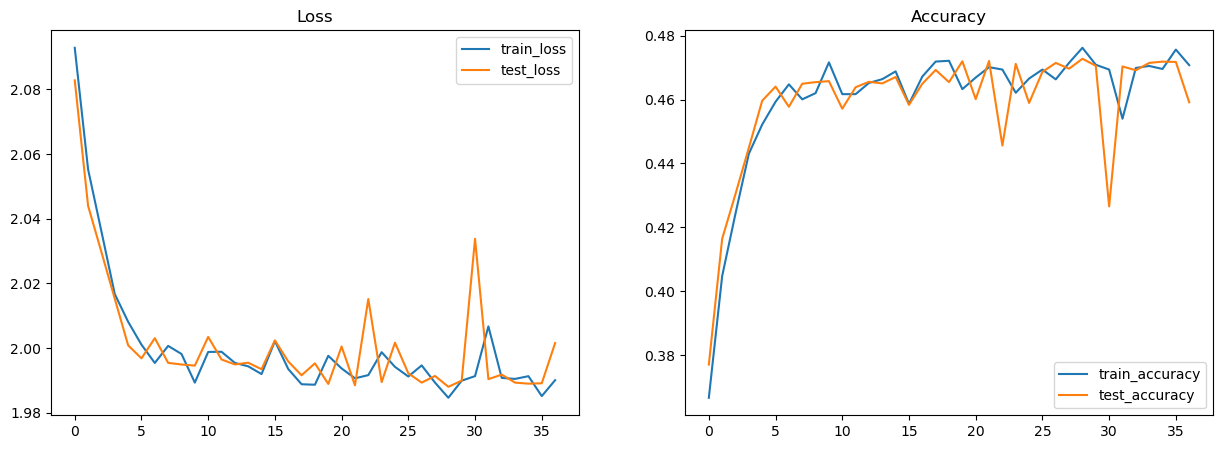

In [61]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
ax1.set_title('Loss')
ax2.set_title('Accuracy')
for dataset in ('train', 'test'):
  ax1.plot(metrics_history[f'{dataset}_loss'], label=f'{dataset}_loss')
  ax2.plot(metrics_history[f'{dataset}_accuracy'], label=f'{dataset}_accuracy')
ax1.legend()
ax2.legend()
plt.show()

## Prediction

Now that training is complete,
our model is ready to [**classify some images.**]


In [62]:
@nnx.jit
def pred_step(model, batch):
  logits = model(batch[0])
  return logits.argmax(axis=1)

test_batch = test_data.as_numpy_iterator().next()
pred = pred_step(model, test_batch)

In [67]:
test_batch[0].shape

(64, 28, 28)

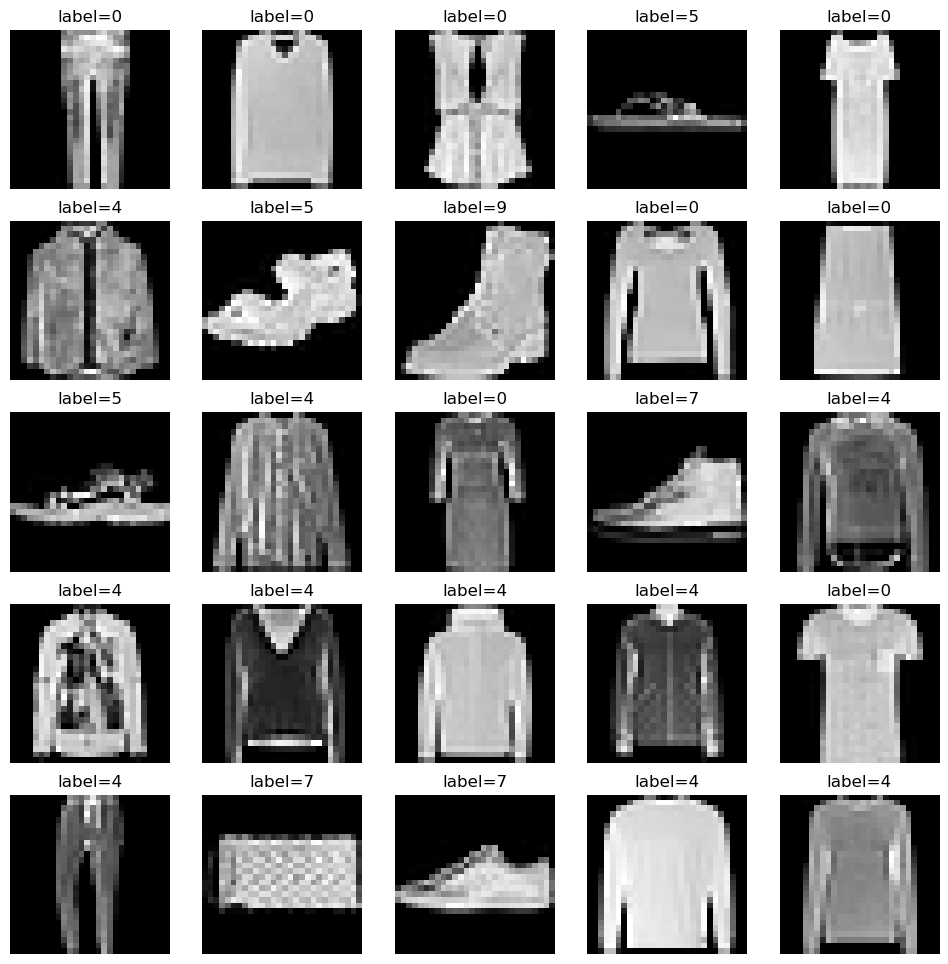

In [68]:
fig, axs = plt.subplots(5, 5, figsize=(12, 12))
for i, ax in enumerate(axs.flatten()):
  ax.imshow(test_batch[0][i, ...], cmap='gray')
  ax.set_title(f'label={pred[i]}')
  ax.axis('off')

## Summary

By now we are starting to get some experience
with solving linear regression
and classification problems.
With it, we have reached what would arguably be
the state of the art of 1960--1970s of statistical modeling.
In the next section, we will show you how to leverage
deep learning frameworks to implement this model
much more efficiently.

## Exercises

1. In this section, we directly implemented the softmax function based on the mathematical definition of the softmax operation. As discussed in :numref:`sec_softmax` this can cause numerical instabilities.
    1. Test whether `softmax` still works correctly if an input has a value of $100$.
    1. Test whether `softmax` still works correctly if the largest of all inputs is smaller than $-100$?
    1. Implement a fix by looking at the value relative to the largest entry in the argument.
1. Implement a `cross_entropy` function that follows the definition of the cross-entropy loss function $\sum_i y_i \log \hat{y}_i$.
    1. Try it out in the code example of this section.
    1. Why do you think it runs more slowly?
    1. Should you use it? When would it make sense to?
    1. What do you need to be careful of? Hint: consider the domain of the logarithm.
1. Is it always a good idea to return the most likely label? For example, would you do this for medical diagnosis? How would you try to address this?
1. Assume that we want to use softmax regression to predict the next word based on some features. What are some problems that might arise from a large vocabulary?
1. Experiment with the hyperparameters of the code in this section. In particular:
    1. Plot how the validation loss changes as you change the learning rate.
    1. Do the validation and training loss change as you change the minibatch size? How large or small do you need to go before you see an effect?


[Discussions](https://discuss.d2l.ai/t/17982)
